In [9]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
import itertools
import yfinance as yf
import datetime

[*********************100%***********************]  1 of 1 completed


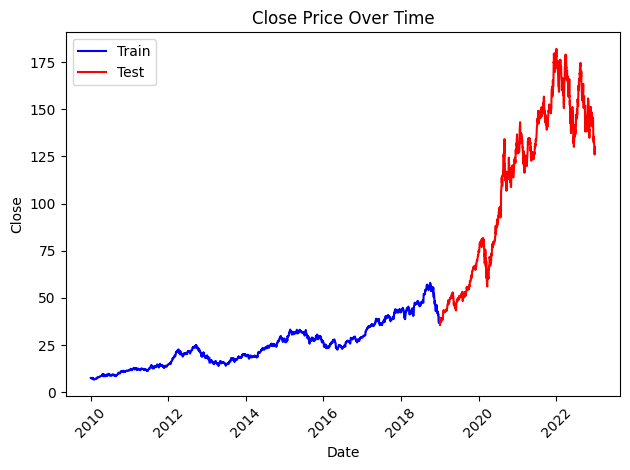

In [5]:
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
period ="train"
data = Data('AAPL',start_date,end_date,period,2019)
data.data_preprocess()

In [10]:
data.data_period = "train"
print("Train period:")
data.comparison_metrics()
data.buy_and_hold()
print("\n")
data.data_period = "test"
print("Test period:")
data.comparison_metrics()
data.buy_and_hold()

Train period:
Return: 2.718073887518733
Portfolio MDD: 1.5264969009628402
Portfolio Std Dev: 0.06411499538936224
Buy and Hold Strategy Profit: 4.75.
Buy and Hold Strategy MDD   : -0.07.


Test period:
Return: 1.6445314828908741
Portfolio MDD: 0.7658672247066628
Portfolio Std Dev: 0.1012646648014138
Buy and Hold Strategy Profit: 2.12.
Buy and Hold Strategy MDD   : -0.04.


Running ring
Generation 1: Best fitness = 13.064905638063667  Average Fitness = 5.648976251122144
Generation 2: Best fitness = 13.659222358092997  Average Fitness = 6.898213253629147
Generation 3: Best fitness = 13.659222358092997  Average Fitness = 8.093184831367171
Generation 4: Best fitness = 13.659222358092997  Average Fitness = 8.597020934171738
Generation 5: Best fitness = 13.659222358092997  Average Fitness = 9.349821211767903
Generation 6: Best fitness = 14.501799310526266  Average Fitness = 9.247097986306898
Generation 7: Best fitness = 14.501799310526266  Average Fitness = 9.729369485764261
Generation 8: Best fitness = 14.501799310526266  Average Fitness = 10.464745942788522
Generation 9: Best fitness = 15.210796485288679  Average Fitness = 10.047070290203568
Generation 10: Best fitness = 15.210796485288679  Average Fitness = 10.861640175353571
Island 0 Migration -Left island 9 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1

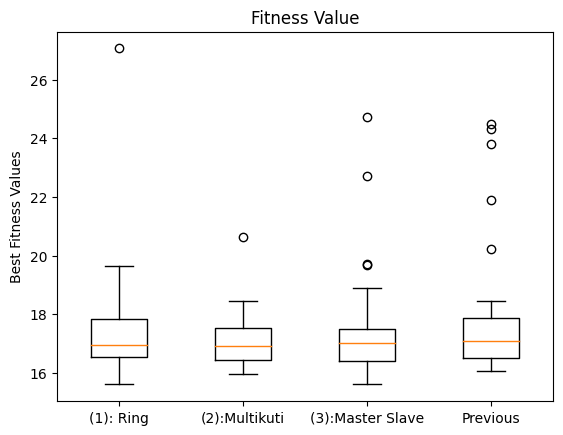

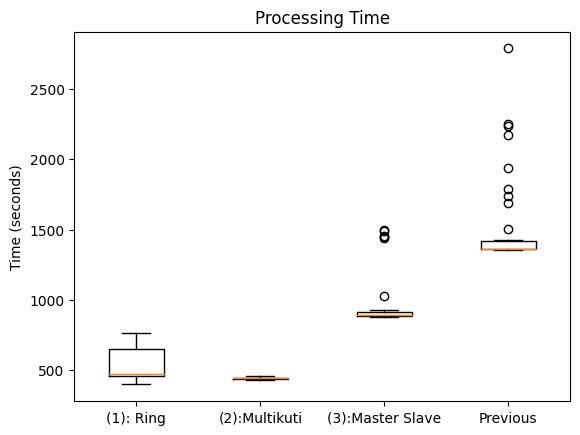

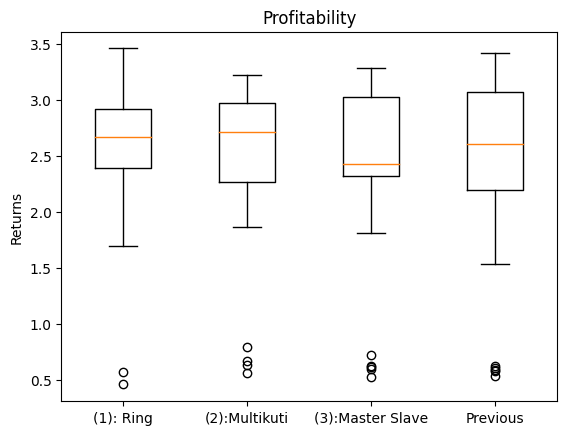

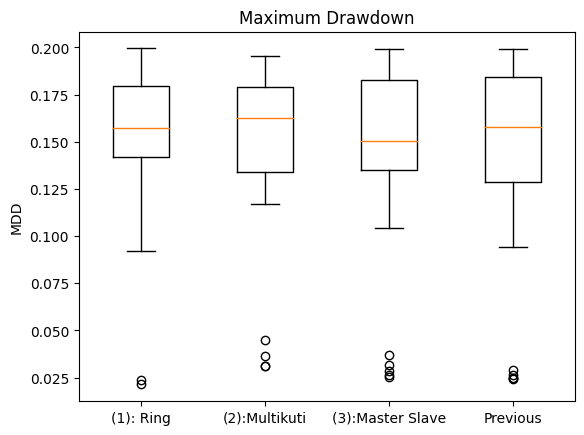

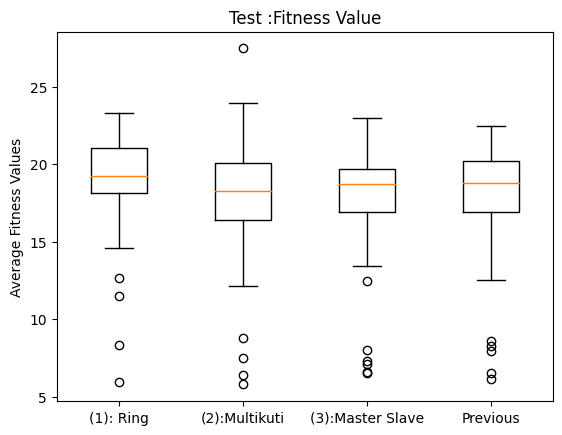

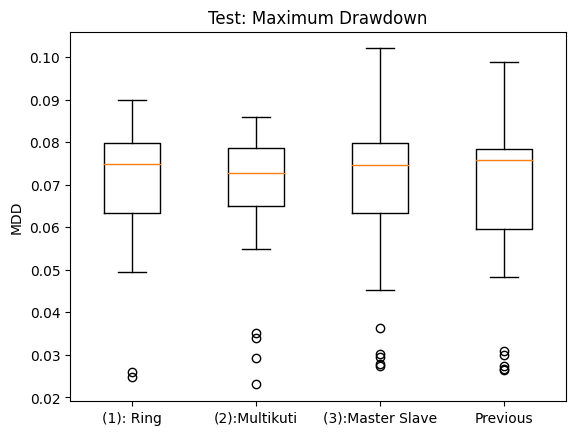

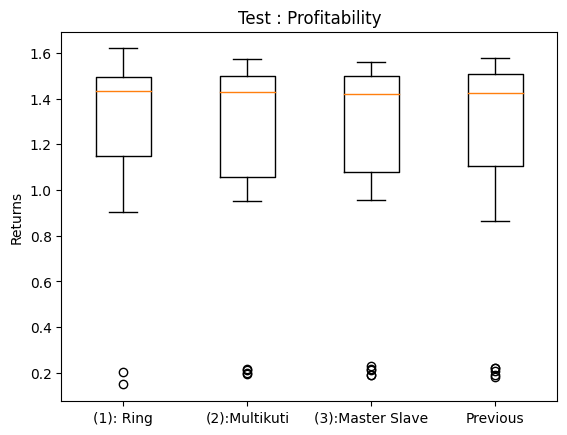

In [11]:
#total return training 
import matplotlib.pyplot as plt

fitness_values = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
test_fitness_values = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
speed_values =  {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
profit = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
test_profit = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
mdd = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
test_mdd = {"ring":[],"multikuti":[],"master_slave":[],"gga":[]}
evolve_strategy =["ring", "multikuti","master_slave","gga"]

for i in evolve_strategy:
    for j in range(40):
        start = time.time()
        ga = IslandGGA(data=data.train_data,K=4,num_islands=10,m_iter=10,num_iter=50,pSize=150,r_cross=0.4,r_mut=0.1,strategies=data.top_strategy_names,evolve_strategy=i)
        ga.evolve()
        end = time.time()
        processing_time=end - start
        speed_values[i].append(processing_time)
        ### USE TRAIN DATA? 
        fitness_values[i].append(ga.globalBest.fitness_value)
        profit[i].append(ga.globalBest.profit)
        mdd[i].append(ga.globalBest.mdd)
        ### USE TEST DATA HERE? 
        ga.globalBest.calculate_chromosome_fitness(data.test_data,1)
        test_fitness_values[i].append(ga.globalBest.fitness_value)
        test_profit[i].append(ga.globalBest.profit)
        test_mdd[i].append(ga.globalBest.mdd)



# Combine the fitness data into a list
fitness_data = [fitness_values[i] for i in  evolve_strategy]

# Create a fitness box plot
fig, ax = plt.subplots()
ax.boxplot(fitness_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Best Fitness Values')

# Set the title of the plot
ax.set_title('Fitness Value')

# Show the plot
plt.show()



#### TIME PLOT
# Combine the time data into a list
speed_data = [speed_values[i] for i in  evolve_strategy]

# Create a time box plot
fig, ax = plt.subplots()
ax.boxplot(speed_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Time (seconds)')

# Set the title of the plot
ax.set_title('Processing Time')

# Show the plot
plt.show()



#### profit
# Combine the profit data into a list
profit_data = [profit[i] for i in  evolve_strategy]

# Create a profit box plot
fig, ax = plt.subplots()
ax.boxplot(profit_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Returns')

# Set the title of the plot
ax.set_title('Profitability')

# Show the plot
plt.show()


#### mdd
# Combine the risk data into a list
mdd_data = [mdd[i] for i in  evolve_strategy]

# Create a risk box plot
fig, ax = plt.subplots()
ax.boxplot(mdd_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('MDD')

# Set the title of the plot
ax.set_title('Maximum Drawdown')

# Show the plot
plt.show()


# Combine the test fitness data into a list
test_fitness_data = [test_fitness_values[i] for i in  evolve_strategy]
# Create a test fitness box plot
fig, ax = plt.subplots()
ax.boxplot(test_fitness_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Average Fitness Values')

# Set the title of the plot
ax.set_title('Test :Fitness Value')
# Show the plot
plt.show()


#### test mdd
# Combine the risk data into a list
test_mdd_data = [test_mdd[i] for i in  evolve_strategy]

# Create a risk box plot
fig, ax = plt.subplots()
ax.boxplot(test_mdd_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('MDD')

# Set the title of the plot
ax.set_title('Test: Maximum Drawdown')

#### profit
# Combine the profit data into a list
test_profit_data = [test_profit[i] for i in  evolve_strategy]

# Create a test profit box plot
fig, ax = plt.subplots()
ax.boxplot(test_profit_data)

# Set the x-axis tick labels
ax.set_xticklabels(['(1): Ring', '(2):Multikuti','(3):Master Slave','Previous'])

# Set the y-axis label
ax.set_ylabel('Returns')

# Set the title of the plot
ax.set_title('Test : Profitability')

# Show the plot
plt.show()

In [10]:
df = pd.DataFrame(test_risk)
df.describe()

,ring,multikuti,master_slave,gga
count,50.000000,50.000000,50.000000,50.000000
mean,0.260308,0.293550,0.218152,0.256219
std,0.604426,0.634712,0.549799,0.593226
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,1.698496,1.698496,1.699628,1.698496
